# IMDB review dataset excercise

In [1]:
import numpy as np 
import pandas as pd 

import os
import re
from tqdm.notebook import tqdm
from termcolor import colored
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from bs4 import BeautifulSoup # for HTML cleanup
# import unicodedata # to deal with accented characters
import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print( 'tf version:', tf.__version__)

tf version: 2.4.0


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import accuracy_score

In [2]:
# limit GPU mem growth (source: https://www.tensorflow.org/guide/gpu)
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True)

# expand notebook to full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
dataset_path = 'u:\\bigdata\\_datasets\\NLP\\IMDB Dataset.csv.zip'
df = pd.read_csv(dataset_path, compression='zip')

In [4]:
df.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

max review length: 13704


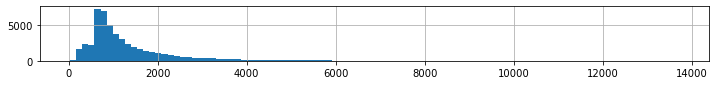

In [5]:
# Distribution of strings lengths'
print("max review length:", df.review.str.len().max())
df.review.str.len().hist(bins=100, figsize = (12,1));

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# encode sentiment as 0 / 1
if df.sentiment.dtype == 'O':
    df.sentiment = (df.sentiment=='positive').astype('int')

# Cleanup:

In [8]:
# remove HTML tags
%time df['review'] = df.review.apply(lambda x: BeautifulSoup(x).get_text())

Wall time: 13.3 s


In [9]:
# Deal with accented characters
import unicodedata

def remove_accented_chars(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

# to test:
# remove_accented_chars('Sómě Áccěntěd těxt. Some words such as résumé, café, prótest, divorcé, coördinate, exposé, latté.')

# %time df['rev'] = df.review.apply(remove_accented_chars)

In [10]:
# remove contracted endings 'll 're 's 'd  etc
%time df['rev'] = df.review.str.replace(r"\'[a-zA-Z]+\s"," ", regex=True)

Wall time: 160 ms


In [11]:
# remove non-letter characters
# remove_pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # longer keep list
remove_pattern = r'[^a-zA-Z]'  # just letters

%time df.rev = df.rev.str.replace(remove_pattern," ", regex=True)

Wall time: 2.87 s


In [12]:
# to lowercase
%time df.rev = df.rev.str.lower()

Wall time: 86 ms


In [13]:
# remove stopwords

nltk.download('stopwords')
tokenizer = nltk.tokenize.ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# len(stopword_list)

def remove_stopwords(x):  
    return' '.join([w for w in tokenizer.tokenize(x) if not w in stopword_list])

%time df.rev =  df.rev.apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wall time: 25.2 s


In [14]:
# LEMMATIZE

lemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')

def lemmatize(x):
    return ' '.join([lemmatizer.lemmatize(w) for w in tokenizer.tokenize(x)])

%time df.rev = df.rev.apply(lemmatize)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Wall time: 31.6 s


In [15]:
df.sample(5)

,review,sentiment,rev
34242,This movie is just a lot of fun. I've seen it ...,1,movie lot fun seen couple time always somethin...
18593,"A good friend of mine one said: ""A monkey is f...",0,good friend mine one said monkey funny anytime...
6051,"This utterly dull, senseless, pointless, spiri...",0,utterly dull senseless pointless spiritless du...
4794,"The acting was very sub-par, You had Costas Ma...",0,acting sub par costa mandalar acting like trip...
32778,One Stinko of a movie featuring a shopworn plo...,0,one stinko movie featuring shopworn plot kind ...


## Limiting vocabulary

In [16]:
# Counting unique words
from collections import Counter
unique_words = Counter()
for review in tqdm(df.rev.values):
    unique_words.update(review.split())
print (f"Unique words: {len(unique_words)}")    

  0%|          | 0/50000 [00:00<?, ?it/s]

Unique words: 91574


In [17]:
# count rare words
print("percent of words in corpus by num of occurences")
print(pd.Series(unique_words.values()).value_counts().head(10)/len(unique_words))

percent of words in corpus by num of occurences
1     0.397995
2     0.116703
3     0.063457
4     0.042872
5     0.031210
6     0.024068
7     0.020715
8     0.016904
9     0.015321
10    0.012023
dtype: float64


In [18]:
# count words by length
print("percent of words in corpus by length")
pd.Series(unique_words.keys(), name="words").str.len().value_counts().to_frame().reset_index().\
    sort_values(by='index').head(10).set_index('index')/len(unique_words)

percent of words in corpus by length


,words
index,
1,0.000273
2,0.005307
3,0.027781
4,0.064516
5,0.108797
6,0.153417
7,0.160810
8,0.143054
9,0.118331


In [19]:
# remove short and infrequent words
min_occurencies = 10
min_word_len = 3

my_vocab = {k:v for k, v in unique_words.items() if v>=min_occurencies and len(k)>= min_word_len}

my_vocab = {k: v for k, v in sorted(my_vocab.items(), key=lambda item: item[1], reverse=True)}

vocab_size = len(my_vocab)
print (f"Words to be used for regression: {vocab_size}") 

Words to be used for regression: 24508


# MODELS

## Naïve Bayes (with limited vocab)

In [20]:
# preparing data for naive Bayes
vectorizer = CountVectorizer(vocabulary = list(my_vocab.keys()))
%time Xv = vectorizer.fit_transform(df.rev.values) 
y = df['sentiment'].values

nb_X_train, nb_X_val, nb_y_train, nb_y_val = train_test_split(
    Xv, df['sentiment'].values, 
    test_size=0.1, random_state=42, stratify=y)

Wall time: 4 s


In [21]:
# run Naïve Bayes model
nb_model = MultinomialNB().fit(nb_X_train, nb_y_train)

nb_y_pred = nb_model.predict(nb_X_val)

nb_score = accuracy_score(nb_y_val, nb_y_pred)
print (f"Naïve Bayes baseline accuracy score: {nb_score:.4}")

# Note: without vocab limit NB scores ~0.861

Naïve Bayes baseline accuracy score: 0.857


## preparing feed for NN models

In [48]:
num_classes = 2

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=len(list(my_vocab)))
tokenizer.fit_on_texts(my_vocab.keys())
X_tokenized = tokenizer.texts_to_sequences(df.rev)
print (f"Input sentences tokenized with {tokenizer.get_config()['num_words']} words vocab")
# y = df.sentiment.values

maxlen = 2000
len_max = df.rev.str.len().max()
print (f"Max cleaned review length: {len_max}; limiting/padding review to {maxlen} words")
X_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_tokenized, maxlen=maxlen, padding='pre',)

X_train, X_val, y_train, y_val = train_test_split(
    X_padded, df['sentiment'].values, 
    test_size=0.1, random_state=42, stratify=y)
print(X_train.shape, X_val.shape)

Input sentences tokenized with 24508 words vocab
Max cleaned review length: 9103; limiting/padding review to 2000 words
(45000, 2000) (5000, 2000)


## simple 2-layer LSTM model (emb 32)

In [142]:
# simple LSTM model
embed_dim = 32

inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(tokenizer.get_config()['num_words'], embed_dim)(inputs)
x = layers.LSTM(128, dropout=0.5, recurrent_dropout=0.0,
                return_sequences=True)(x)
x = layers.LSTM(64, dropout=0.5, recurrent_dropout=0.0,
                return_sequences=False)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_e32 = tf.keras.Model(inputs, outputs)
model_e32.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.002),
              metrics=['accuracy'])

model_e32.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_17 (Embedding)     (None, None, 32)          784256    
_________________________________________________________________
lstm_27 (LSTM)               (None, None, 128)         82432     
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 202 

In [143]:
history_e32 = model_e32.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=6, batch_size=64, verbose=1, callbacks=callback)

Epoch 1/6
704/704 [==============================] - 113s 156ms/step - loss: 0.4775 - accuracy: 0.7520 - val_loss: 0.2814 - val_accuracy: 0.8834
Epoch 2/6
704/704 [==============================] - 109s 154ms/step - loss: 0.2322 - accuracy: 0.9129 - val_loss: 0.2702 - val_accuracy: 0.8962
Epoch 3/6
704/704 [==============================] - 109s 155ms/step - loss: 0.1725 - accuracy: 0.9387 - val_loss: 0.2997 - val_accuracy: 0.8886
Epoch 4/6
704/704 [==============================] - 109s 155ms/step - loss: 0.1397 - accuracy: 0.9503 - val_loss: 0.2839 - val_accuracy: 0.8896


In [120]:
print (f"LSTM model accuracy: {max(model_e32.history.history['val_accuracy']):.4f}")

LSTM model accuracy: 0.8958


## Bidirectional LSTM model
https://keras.io/examples/nlp/bidirectional_lstm_imdb/

In [151]:
# Input for variable-length sequences of integers
embed_dim = 300

inputs = layers.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(tokenizer.get_config()['num_words'], embed_dim)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)
model_3.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 300)         7352400   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         186880    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_29 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202 

In [42]:
model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.005),
              metrics=['accuracy'])


history_3 = model_3.fit(X_train, y_train, 
                  validation_data=(X_val, y_val),
                  epochs=6, batch_size=64, verbose=1, callbacks=callback)

Epoch 1/6
704/704 [==============================] - 239s 332ms/step - loss: 0.4728 - accuracy: 0.7855 - val_loss: 0.3355 - val_accuracy: 0.8714
Epoch 2/6
704/704 [==============================] - 232s 329ms/step - loss: 0.2610 - accuracy: 0.9019 - val_loss: 0.2633 - val_accuracy: 0.8932
Epoch 3/6
704/704 [==============================] - 233s 331ms/step - loss: 0.1565 - accuracy: 0.9469 - val_loss: 0.3118 - val_accuracy: 0.8866
Epoch 4/6
704/704 [==============================] - 233s 331ms/step - loss: 0.0852 - accuracy: 0.9735 - val_loss: 0.3130 - val_accuracy: 0.8752


In [128]:
# y_pred = model_3.predict(X_val)
# score = accuracy_score(y_val, y_pred.argmax(axis=1))
# model_3.history.history
print (f"Bidirectional LSTM model accuracy: {max(history_3.history['val_accuracy']):.4f}")

Bidirectional LSTM model accuracy: 0.8932


## transformer
based on https://keras.io/examples/nlp/text_classification_with_transformer/

In [131]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [132]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [140]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer


inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model_t = keras.Model(inputs=inputs, outputs=outputs)

In [141]:
model_t.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2000)]            0         
_________________________________________________________________
token_and_position_embedding (None, 2000, 32)          848256    
_________________________________________________________________
transformer_block_1 (Transfo (None, 2000, 32)          10656     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 20)                660       
_________________________________________________________________
dropout_14 (Dropout)         (None, 20)                0   

In [144]:
model_t.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [145]:
history_t = model_t.fit(X_train, y_train, 
                  validation_data=(X_val, y_val),
                  epochs=6, batch_size=32, verbose=1, callbacks=callback)

Epoch 1/6
1407/1407 [==============================] - 295s 208ms/step - loss: 0.6819 - accuracy: 0.5205 - val_loss: 0.3261 - val_accuracy: 0.8602
Epoch 2/6
1407/1407 [==============================] - 291s 207ms/step - loss: 0.2575 - accuracy: 0.8966 - val_loss: 0.2421 - val_accuracy: 0.9036
Epoch 3/6
1407/1407 [==============================] - 290s 206ms/step - loss: 0.1777 - accuracy: 0.9352 - val_loss: 0.2516 - val_accuracy: 0.8986
Epoch 4/6
1407/1407 [==============================] - 290s 206ms/step - loss: 0.1239 - accuracy: 0.9573 - val_loss: 0.3137 - val_accuracy: 0.8944


In [146]:
# y_pred = model_3.predict(X_val)
# score = accuracy_score(y_val, y_pred.argmax(axis=1))
# model_3.history.history
print (f"Transformer model accuracy: {max(history_t.history['val_accuracy']):.4f}")

Transformer model accuracy: 0.9036


## BERT attempt 1

In [1]:
# prereq: install Hugging Face transformers (conda has it)
import transformers

In [56]:
import importlib
importlib.reload(transformers)

<module 'transformers' from 'c:\\conda\\envs\\cuda11\\lib\\site-packages\\transformers\\__init__.py'>

In [2]:
b_tokenizer = transformers.BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True)

b_tokenizer_c = transformers.BertTokenizer.from_pretrained("bert-base-cased")

In [40]:
model = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
ds_train = tf.data.Dataset.from_tensor_slices((df.rev, df.sentiment))

In [ ]:
my_dataset = tf.data.experimental.CsvDataset

In [77]:
data['train']

<PrefetchDataset shapes: {idx: (), label: (), sentence1: (), sentence2: ()}, types: {idx: tf.int32, label: tf.int64, sentence1: tf.string, sentence2: tf.string}>

In [51]:
ds_train

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [87]:
gg = transformers.glue_convert_examples_to_features(
    examples=ds_train.prefetch(1000), task='mrpc',
    tokenizer=b_tokenizer)

TypeError: tuple indices must be integers or slices, not str

In [46]:
df.rev.shape

(50000,)

In [89]:
len(ds_train.prefetch(1000))

50000

In [88]:
len(data['train'])

3668

In [28]:
b_tokenizer.model_max_length

512

In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [79]:
data = tfds.load('glue/mrpc')

INFO:absl:Load dataset info from C:\Users\rs\tensorflow_datasets\glue\mrpc\1.0.0
INFO:absl:Reusing dataset glue (C:\Users\rs\tensorflow_datasets\glue\mrpc\1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from C:\Users\rs\tensorflow_datasets\glue\mrpc\1.0.0


In [ ]:
gg = transformers.glue_convert_examples_to_features(
    examples=df.rev[:10].values, label_list = df.sentiment[:10].values,
    tokenizer=b_tokenizer_c)

In [ ]:
AttributeError                            Traceback (most recent call last)
<ipython-input-52-c53eee72a7c2> in <module>
----> 1 gg = transformers.glue_convert_examples_to_features(
      2     examples=df.rev[:10],
      3     tokenizer=b_tokenizer_c)

c:\conda\envs\cuda11\lib\site-packages\transformers\data\processors\glue.py in glue_convert_examples_to_features(examples, tokenizer, max_length, task, label_list, output_mode)
     70             raise ValueError("When calling glue_convert_examples_to_features from TF, the task parameter is required.")
     71         return _tf_glue_convert_examples_to_features(examples, tokenizer, max_length=max_length, task=task)
---> 72     return _glue_convert_examples_to_features(
     73         examples, tokenizer, max_length=max_length, task=task, label_list=label_list, output_mode=output_mode
     74     )

c:\conda\envs\cuda11\lib\site-packages\transformers\data\processors\glue.py in _glue_convert_examples_to_features(examples, tokenizer, max_length, task, label_list, output_mode)
    117 ):
    118     if max_length is None:
--> 119         max_length = tokenizer.max_len
    120 
    121     if task is not None:

AttributeError: 'BertTokenizer' object has no attribute 'max_len'

In [202]:
%%time
t = 'this is a sample text'
str_list = df.loc[:2,'rev'].values.tolist()
X_bt = b_tokenizer.batch_encode_plus(df.rev.values.tolist(), 
                                     max_length=maxlen,
                                     truncation=True,
                                     padding=True,
                                     add_special_tokens=True,
                                     return_attention_mask=True,
                                     return_token_type_ids=True,
                                     return_tensors="tf",)

Wall time: 2min 47s


In [203]:
X_bt['input_ids'].shape

TensorShape([50000, 1669])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_bt, df['sentiment'].values, 
    test_size=0.1, random_state=42, stratify=y)
print(X_train.shape, X_val.shape)

In [ ]:
%time X_bt = [b_tokenizer.encode(str_, max_length=maxlen, truncation=True) for str_ in df.rev]

In [161]:
len(X_bt)

2000

In [ ]:
mlm_model = tf.keras.models.load_model(
    "bert_mlm_imdb.h5",
#     custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = tf.keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0/ffn_layernormalization").output
)

## Bert-2d attempt
ref Kaggle bert example: https://www.kaggle.com/viroviro/detecting-disaster-tweets-fine-tuning-bert

In [46]:
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from transformers import AutoConfig

PRETRAINED_MODEL_NAME = 'bert-base-uncased'
# The number of labels of the target variable
LABELS_NUMBER = 2

# The max lenght of text can be up to 512 for BERT
MAX_LENGHT = 256


BATCH_SIZE = 6
LEARNING_RATE = 2e-5
EPOCHS_NUMBER = 1

N_PREDICTIONS_TO_SHOW = 10

In [47]:
# Get the Bert tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME, 
                                          do_lower_case=True)

vocabulary = tokenizer.get_vocab()
print(f'Size of the vocabulary: {len(vocabulary)}')
print(f'Some tokens of the vocabulary: {list(vocabulary.keys())[5000:5010]}')

Size of the vocabulary: 30522
Some tokens of the vocabulary: ['knight', 'lap', 'survey', 'ma', '##ow', 'noise', 'billy', '##ium', 'shooting', 'guide']


In [48]:
def prepare_sequence(text, tokenizer):
    """
    Tokenize and prepare a sequence for the model. It tokenizes the text sequence
    adding special tokens ([CLS], [SEP]), padding  to the max length and truncate 
    reviews longer than the max length.
    Return the token IDs, the segment IDs and the mask IDs.
    """

    prepared_sequence = tokenizer.encode_plus(
                            text, 
                            add_special_tokens = True, 
                            max_length = MAX_LENGHT, 
                            padding = 'max_length',
                            return_attention_mask = True,
                            truncation = True,
                            )
    return prepared_sequence

In [49]:
# Prepare a test sentence
test_sentence = 'Semantic Similarity is the task of determining how similar two sentences are.'
test_sentence_encoded = prepare_sequence(test_sentence, tokenizer)
token_ids = test_sentence_encoded["input_ids"]
print(f'Test sentence:   {test_sentence}')
print(f'Keys:            {test_sentence_encoded.keys()}')
print(f'Tokens:          {tokenizer.convert_ids_to_tokens(token_ids)[:16]}')
print(f'Token IDs:       {token_ids[:12]}')
print(f'Segment IDs:     {test_sentence_encoded["token_type_ids"][:16]}')
print(f'Mask IDs         {test_sentence_encoded["attention_mask"][:16]}')
print(f'Input dimension: {len(token_ids)}')

Test sentence:   Semantic Similarity is the task of determining how similar two sentences are.
Keys:            dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Tokens:          ['[CLS]', 'semantic', 'similarity', 'is', 'the', 'task', 'of', 'determining', 'how', 'similar', 'two', 'sentences', 'are', '.', '[SEP]', '[PAD]']
Token IDs:       [101, 21641, 14402, 2003, 1996, 4708, 1997, 12515, 2129, 2714, 2048, 11746]
Segment IDs:     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Mask IDs         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Input dimension: 256


In [50]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    """
    Map to the expected input to TFBertForSequenceClassification.
    """
    mapped_example = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }
    return mapped_example, label 

def encode_examples(texts, labels):
    """
    Prepare all sequences of text and build TF dataset.
    """
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
        
    for text, label in tqdm(zip(texts, labels), total=len(labels)):

        bert_input = prepare_sequence(text, tokenizer)

        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    # Create TF dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (input_ids_list, attention_mask_list, token_type_ids_list,
         label_list)
    )
    # Map to the expected input to TFBertForSequenceClassification
    dataset_mapped = dataset.map(map_example_to_dict)
    return dataset_mapped

In [51]:
# Split the training dataset for training and test
X_train, X_val, y_train, y_val = train_test_split(df.rev, df.sentiment,
                                                  test_size=0.10, random_state=42)

In [52]:
n_training_examples = X_train.shape[0]
n_positive_training_examples = y_train.value_counts()[1]
n_negative_training_examples = y_train.value_counts()[0]
print(f'Number examples in training dataset: {n_training_examples}')
print(f'Number of positive examples in training dataset: {n_positive_training_examples}')
print(f'Number of negative examples in training dataset: {n_negative_training_examples}')

Number examples in training dataset: 45000
Number of positive examples in training dataset: 22481
Number of negative examples in training dataset: 22519


In [54]:
# Prepare sequences of text and build TF train dataset
ds_train_encoded = encode_examples(X_train, y_train).shuffle(10000).batch(BATCH_SIZE)



  0%|          | 0/45000 [00:00<?, ?it/s]

In [53]:
# Prepare sequences of text and build TF validation dataset
ds_val_encoded = encode_examples(X_val, y_val).batch(BATCH_SIZE)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [55]:
def get_model():
    # Define the configuration of the model
    config = AutoConfig.from_pretrained(PRETRAINED_MODEL_NAME,
                                        hidden_dropout_prob=0.2,
                                        num_labels=LABELS_NUMBER)
    # Model initialization
    model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, 
                                                            config=config)c
    return model

# Model initialization
model = get_model()

# Define the optimizer, the loss function and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
# Train the model
model.fit(ds_train_encoded, epochs=EPOCHS_NUMBER, validation_data=ds_val_encoded)

7500/7500 [==============================] - 2396s 318ms/step - loss: 0.3637 - accuracy: 0.8338 - val_loss: 0.2312 - val_accuracy: 0.9078


In [58]:
model.fit(ds_train_encoded, epochs=2, validation_data=ds_val_encoded)

Epoch 1/2
7500/7500 [==============================] - 2352s 314ms/step - loss: 0.0368 - accuracy: 0.9877 - val_loss: 0.3661 - val_accuracy: 0.8980
Epoch 2/2
7500/7500 [==============================] - 2354s 314ms/step - loss: 0.0318 - accuracy: 0.9899 - val_loss: 0.4563 - val_accuracy: 0.9038


In [ ]:
model.fit(ds_train_encoded, epochs=3, validation_data=ds_val_encoded)

Epoch 1/3
7500/7500 [==============================] - 2355s 314ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.4844 - val_accuracy: 0.9052
Epoch 2/3
3370/7500 [============>.................] - ETA: 20:55 - loss: 0.0354 - accuracy: 0.9902